**GUIA 5**

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy import fft
from IPython.display import HTML
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from tqdm.notebook import tqdm
from scipy.signal import find_peaks
from scipy.optimize import curve_fit

**Ejercicio 1: Modelo de presa predador Lotka-Volterra**

---



El modelo de Lotka-Volterra describe la dinámica de interacción de dos poblaciones, y esta dado por

$$ u_t =   au - buv + D_1 u_{xx}, $$
$$ v_t = - cv + duv + D_2 v_{xx}. $$

En estas ecuaciones $u(x,t)$ es la densidad de presas, $v(x,t)$ la de predadores, $a$ la tasa de nacimiento de presas, $c$ la tasa de muerte de predadores, $b$ y $d$ son los acoplamientos entre especies, y $D_1$ y $D_2$ sus difusividades.


**a**) Resolvé numéricamente el sistema considerando condiciones de contorno periódicas en el dominio unidimensional $x \in [0,2\pi)$, utilizando un método a elección. Elegí todos los parámetros y definí las condiciones iniciales para $u$ y para $v$. Explicá detalladamente la elección del método, de los parámetros y de las condiciones iniciales. Describí la dinámica del sistema en término de las soluciones obtenidas.

**b**) Utilizando tu modelo numérico mostrá el efecto que tienen los coeficientes de difusión en el modelo. *Ayuda: probá distintos valores de* $D_1$ y $D_2$

## a)

In [2]:
def compute_prod(fu, fv, k):
    u  =  np.fft.irfft(fu)
    v  =  np.fft.irfft(fv)
    prod   = u*v
    out = np.fft.rfft(prod)
    return out

def evol2(u, v, k, a, b, c, d, D1, D2, N, dt):
    fu  = np.fft.rfft(u)
    fv  = np.fft.rfft(v)
    ftu = fu
    ftv = fv
    for ord in [2,1]:
        D   = dt/ord
        fuv = compute_prod(fu, fv, k)
        fu   = ftu + D*(a*fu - b*fuv -D1*k**2*fu)
        fv   = ftv + D*(-c*fv + d*fuv - D2*k**2*fv)
        fu[int(N/3):] = 0
        fv[int(N/3):] = 0
    outu = np.fft.irfft(fu)
    outv = np.fft.irfft(fv)
    return outu, outv

In [10]:
#Se  definen los  puntos en el espacio real y los modos para el espacio de Fourier
N = 512
# a, b, c, d, D1, D2 = 1, 5, 0.1, 0.4, 0.01, 0.01
a, b, c, d, D1, D2 = 1, 0.02, 2, 0.02, 0.001, 0.001

dt = 5e-4
tf = 60
step = int(tf/dt)

x = np.linspace(0, 2*np.pi,N,endpoint=False) # Coordenada espacial en [0,2*pi)
t = np.arange(step)*dt                       # Tiempo
k = np.arange(0,N/2+1)                       # Números de onda ordenados como en la FFT

outu = np.zeros((N,step))
outv = np.zeros((N,step))

outu[:, 0] = 100 + 100*np.cos(x) #Condiciones iniciales
outv[:, 0] = 100 + 100*np.cos(x)  #Condiciones iniciales
for i in tqdm(np.arange(step-1)): # Evolución temporal
    outu[:,i+1], outv[:,i+1] = evol2(outu[:,i], outv[:,i], k, a, b, c, d, D1,
                                     D2, N, dt)

  0%|          | 0/119999 [00:00<?, ?it/s]

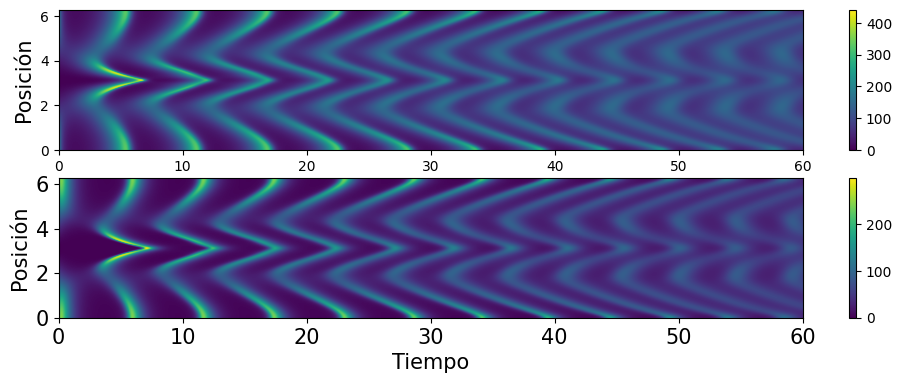

In [12]:
#energia = np.mean(out**2, axis=0)
extent = [0, step*dt, 0, 2*np.pi]

fig, ax = plt.subplots(2, 1, figsize=(12, 4),sharey=True)
ax[0].imshow(outu, aspect = 'auto', extent = extent)
ax[0].set_xlabel('Tiempo', fontsize = 15)
ax[0].set_ylabel("Posición", fontsize = 15)
ax[1].imshow(outv, aspect = 'auto', extent = extent)
ax[1].set_xlabel('Tiempo', fontsize = 15)
ax[1].set_ylabel("Posición", fontsize = 15)
plt.xlabel('Tiempo', fontsize = 15)
plt.ylabel("Posición", fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
fig.colorbar(ax[0].imshow(outu, aspect = 'auto', extent = extent), ax=ax[0])
fig.colorbar(ax[1].imshow(outv, aspect = 'auto', extent = extent), ax=ax[1])

(0.0, 1.0)

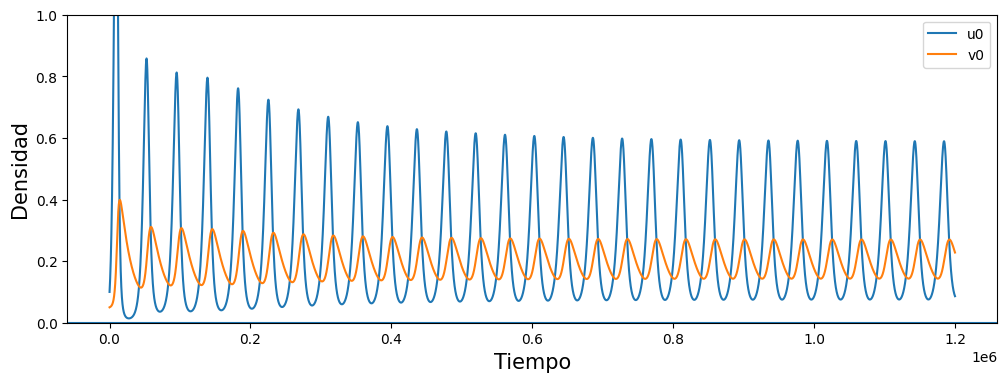

In [ ]:
plt.figure(figsize=(12, 4))
plt.plot(outu[64,:], label='u0')
plt.plot(outv[64,:], label='v0')
plt.xlabel('Tiempo', fontsize = 15)
plt.ylabel("Densidad", fontsize = 15)
plt.legend()
plt.axhline(0)
plt.ylim(0,1)

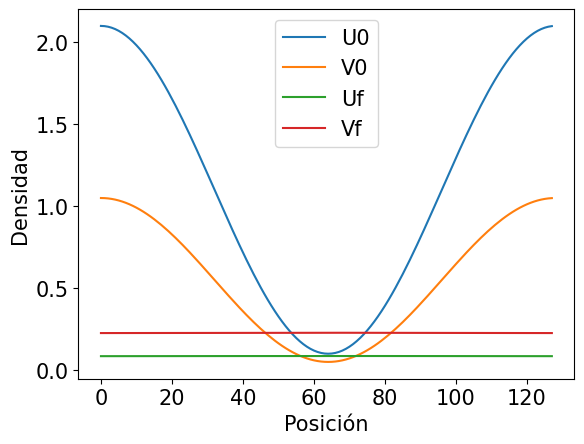

In [ ]:
plt.plot(outu[:,0], label='U0')
plt.plot(outv[:,0], label='V0')
plt.plot(outu[:,-1], label='Uf')
plt.plot(outv[:,-1], label='Vf')
plt.xlabel('Posición', fontsize = 15)
plt.ylabel("Densidad", fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(fontsize = 15)

**Ejercicio 2: Modelo para la propagación del fuego, ecuación de Kuramoto-Sivashinsky**

---




La ecuación de Kuramoto-Sivashinsky viene dada por

$$ u_t = -u_{xx} -u_{xxxx} - (u_x)^2/2 $$

Derivando respecto a x y tomando $v = u_x$ se tiene

$$ v_t = -v_{xx} -v_{xxxx} - vv_x, $$

de donde puede verse que el término $v_{xx}$ representa la reacción, que $v_{xxxx}$ es el término de disipación y $vv_x$ es el término advectivo.


**a**) ¿Qué simetrías tiene esta ecuación? Basado en esto, y dado un dominio de longitud L y cdc periódicas elegí una base de Fourier y escribí una proyección de Galerkin de esta ecuación, hasta llegar a la expresión explícita para la evolución temporal del sistema.

**b**) Escribi explícitamente los primeros cuatro modos y estudiá la primera bifrucación del sistema (a dos modos). A partir de esto, ¿Qué esperás que pase al agregar mas modos?

**c**) Integrá la ecuación numéricamente con condiciones de contorno periódicas, utilizando un método numérico a elección. *Ayuda: Para trabajar con una variable $x \in [0,2\pi)$ y poder cambiar fácilmente la longitud total del recinto a *$2\pi L$, *redefini* $x'=x/L$ y $t'=t/L^2$. *La ecuación que se obtiene entonces es*

$$ u_{t'} = -u_{x'x'} -u_{x'x'x'x'}/L^2 - (u_{x'})^2/2 $$

Qué pasa si se extiende el dominio espacial a $n\pi$ (probá con distintos L)? Explicá detalladamente la dinámica que ves en relación al item previo (Ayuda: usa gráficos 2D de la solución obtenida). Es posible caracterizar las soluciones con unos pocos modos?

Para las $u(x,t)$ obtenidas numéricamente, puede resultar de mucha utilidad trabajar con la función de estructura de orden 2 de la velocidad, dada por

$$ S_2(l,t) = < [u(x+l,t)-u(x,t)]^2 > = <\delta u_l^2>  $$

la cual tiene un vínculo directo con el espectro de Energía  en el espacio de Fourier $E(k)$ ($S_2$ es la "energía en el espacio real"). De esta forma, ya sea con $E(k)$ o $S_2$, es posible argumentar acerca de la dinámica del sistema en términos de la cantidad de modos que estan excitados en la proyección de Galerkin, y de cual es su amplitud. Pero mas aún, en sistemas autosimilares, es posible hallar la dimension fractal del sistema. Si además el sistema es monofractal, toda la estadistica del sistema queda unívocamente determinada por $S_2$.^

**d**) Calculá la función de estructura $S_2(l)$ y el espectro de energía $E(k)$, para distintos tiempos. Graficá promedios de $S_2(l)$ y $E(k)$ en el estado estacionario. Justificá.

**e**)A partir de estos, hallá un rango de autosimilaridad para el cual puedan escribirse leyes de scala de la forma $E(k)\sim k^{\alpha}$ y $S_2(l)\sim l^{\beta}$. De acuerdo entonces a las soluciones numéricas, cuánto valen $\alpha$ y $\beta$? Qúe relación guardan entre si? Es lo esperado?

**f**) Opcional: Hallá la dimensión fractal, D, del sistema. Argumentá. El valor obenido refleja las estructuras que ves en los gráficos de $u(x,t)$?










## c)

In [48]:
def compute_advection(f,k,N):
    # Calcula v*vx usando el método pseudoespectral y devuelve el resultado en el espacio Fourier
    fx  = 1j*k*f                      #derivamos
    v   =  np.fft.irfft(fx)            # vuelva para poder multiplicar!
    #vx  =  np.fft.irfft(fx)                           # eso de arriba
    v   =(v**2)*0.5
    out = np.fft.rfft(v)
    return out



def evol(u,k,L,N,dt):
    # Evoluciona en el tiempo la PDE usando el método pseudoespectral y Runge-Kutta de segundo orden
    f  = np.fft.rfft(u)     #vaya al espacio de Fourier
    ft = f
    for ord in [2,1]:       # Bucle para el Runge-Kutta
        D   = dt/ord
        fux = compute_advection(f,k,N)  # Calcula el término no-lineal
        fuxxxx = f*(k**4)/L**2
        fuxx = f*k**2        # Calcula el término dispersivo
        f   = ft+ D*(-fux- fuxxxx + fuxx)        # escriba aquí su integrador temporal
        f[int(N/3):] = 0
        if np.sum(np.isnan(f))==True:
          stop              # Dealiasing (eliminemos modos espúreos!)
    out = np.fft.irfft(f)               #Vuelva del espacio de Fourier
    return out


In [49]:
#Se  definen los  puntos en el espacio real y los modos para el espacio de Fourier
N =  1024#2048
L =  200#400
dt = 1e-7
step = 100000
tf = step*dt

x = np.linspace(0,2*np.pi,N,endpoint=False) # Coordenada espacial en [0,2*pi)
t = np.arange(step)*dt                      # Tiempo
k = np.arange(0,N/2+1)                      # Números de onda ordenados como en la FFT

out = np.zeros((N,step))
a = 1
out[:,0] = np.sin(a*x) #Condiciones iniciales
for i in tqdm(np.arange(step-1)): # Evolución temporal
    out[:,i+1] = evol(out[:,i],k,L,N,dt)     #Completa para integrar (mira el bloque anterior)

out = out - np.mean(out, axis=0)[np.newaxis, :] #le resto la media

  0%|          | 0/99999 [00:00<?, ?it/s]

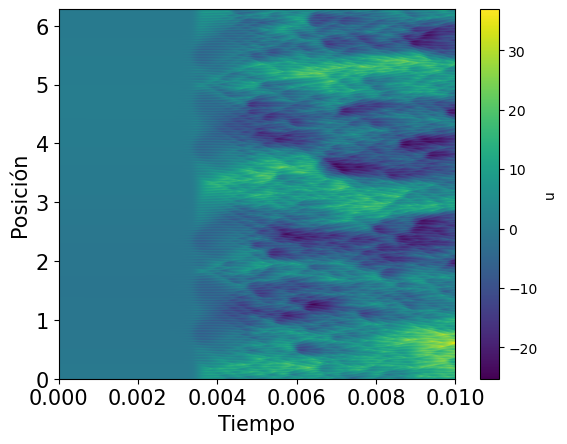

In [50]:
# energia = np.mean(out**2, axis=0)

extent = [0, step*dt, 0, 2*np.pi]
plt.imshow(out, aspect = 'auto', extent = extent)

plt.colorbar(label = 'u')
plt.xlabel('Tiempo', fontsize = 15)
plt.ylabel("Posición", fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15);
# plt.xlim(0,.3)
# plt.ylim(0,1)

**Aqui abajo bloques de codigo para los items d) en adelante**

$$ S_2(l,t) = < [u(x+l,t)-u(x,t)]^2 > = <\delta u_l^2>  $$

In [54]:
#Modulo para calcular funciones de estructura de orden 2
#u = array(N,step) son las fluctuaciones de la velocidad que se obtiene de reso

Str = 0.
start = int(0.006 / dt) #0.1 porque es donde vimos a ojo que empieza el estacionario
npoint =int(N/2)  
stop = step-npoint #hasta el final

inc = 2*npoint
nfile = int((stop-start)/npoint+1)     #esto podria ser step...
for i in np.arange(start,stop,npoint):    #npoint puede ser 1...
    # print(i)
    St = np.zeros(inc)
    ini = 0
    end = inc
    for j in np.arange(0,inc):
        # print(out[ini:end-j,i].shape)
        # print(out[ini+j:end,i].shape)
        s = np.mean((out[ini:end-j,i] - out[ini+j:end,i])**2.)
        St[j] = s 
    Str = Str + St #creemos que para hacer promedio temporal
S_2 = Str/nfile


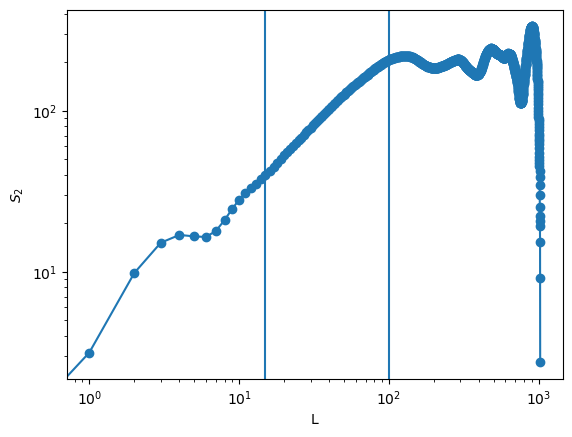

In [101]:
L = np.arange(0,N)
plt.plot(L,S_2,marker='o')
plt.xlabel('L')
plt.ylabel('$S_2$')
# plt.plot(x,x**2)
plt.axvline(15,color='C0')
plt.axvline(100,color='C0')
plt.xscale('log')
plt.yscale('log')

In [29]:
# Modulo para el espectro (pueden usar otro metodo!)
En = 0.
for i in np.arange(start,stop,npoint):
    E = np.zeros(int(inc/2)+1)
    ini = 0
    end = inc
    ps = np.fft.rfft(np.abs(out[:,i])**2) #ACA CALCULO EL ESPECTRO
    f = np.fft.rfftfreq(out.shape[0], L/N)#ACA LAS FRECUENCIAS
    En = ps + E
E = En/nfile

# Si x*L es la coordenada espacial
k = 2*np.pi*f  #numero de onda

ValueError: operands could not be broadcast together with shapes (257,) (512,) 

In [75]:
f = np.fft.fftfreq(out.shape[0], L/N)
k = 2*np.pi*f
E_fft = np.mean(np.abs(np.fft.fft(out,axis = 0))**2,axis = 1)
E_fft = E_fft[0:N//3]

print(k.shape,E_fft.shape)


/opt/anaconda3/lib/python3.11/site-packages/numpy/fft/helper.py:162: RuntimeWarning: divide by zero encountered in divide
  val = 1.0 / (n * d)
/opt/anaconda3/lib/python3.11/site-packages/numpy/fft/helper.py:169: RuntimeWarning: invalid value encountered in multiply
  return results * val


(1024,) (341,)


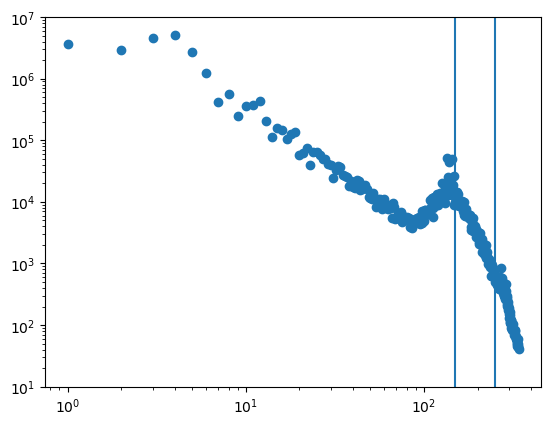

In [76]:
x = np.arange(0,len(E_fft))
plt.plot(E_fft,marker='o',ls='')
plt.axvline(150)
plt.axvline(250)
plt.ylim(10,10e6)
plt.xscale('log')
plt.yscale('log')
# plt.grid()
# plt.ylim(0.1)


In [77]:
#Best fit (pueden usarlo para S2 y E)

logA = np.log(x[150:250])
logB = np.log(E_fft[150:250])
m, c = np.polyfit(logA, logB, 1,cov=True)
print(m)

[-5.92063392 39.26833716]


[-2.04809548 17.49914762]


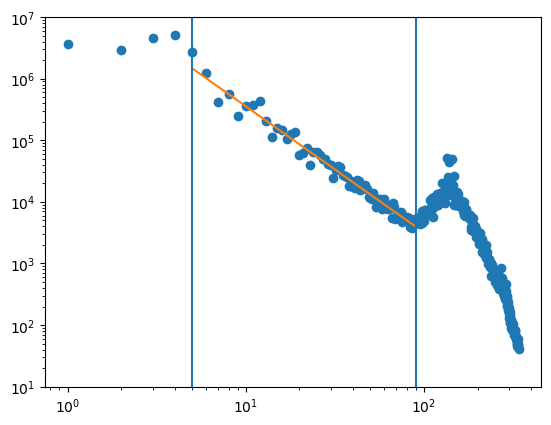

In [115]:
beg = 5
end = 90

logA = np.log(x[beg:end])
logB = np.log(E_fft[beg:end])
m, c = np.polyfit(logA, logB, 1,cov=True)
print(m)

x = np.arange(0,len(E_fft))
plt.plot(x,E_fft,marker='o',ls='')
plt.plot(np.exp(logA),np.exp(logA*m[0]+m[1]))
plt.axvline(beg)
plt.axvline(end)
plt.ylim(10,10e6)
plt.xscale('log')
plt.yscale('log')

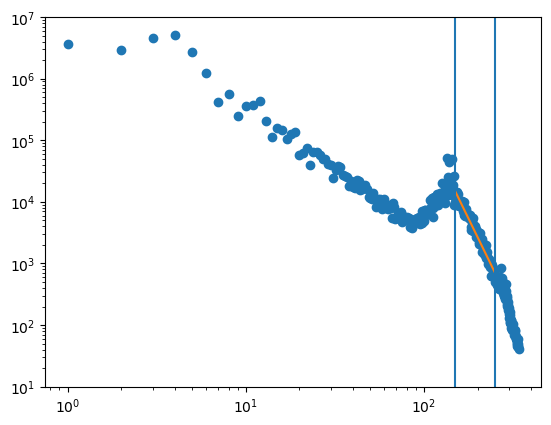

In [90]:
x = np.arange(0,len(E_fft))
plt.plot(x,E_fft,marker='o',ls='')
plt.plot(np.exp(logA),np.exp(logA*m[0]+m[1]))
plt.axvline(150)
plt.axvline(250)
plt.ylim(10,10e6)
plt.xscale('log')
plt.yscale('log')

In [113]:
#Best fit (pueden usarlo para S2 y E)
beg = 10
end = 80
L = np.arange(0,N)
logA = np.log(L[beg:end])
logB = np.log(S_2[beg:end])
m, c = np.polyfit(logA, logB, 1,cov=True)
print(m)

[0.91495037 1.23640053]


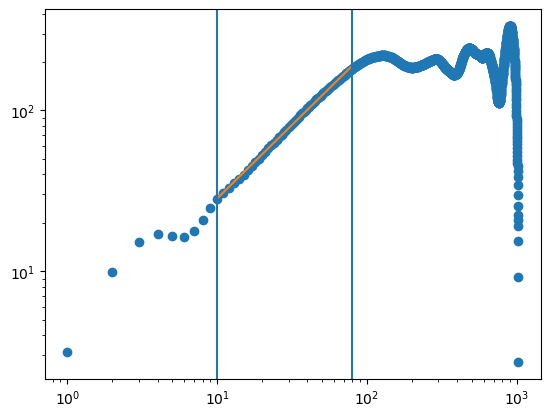

In [114]:
x = np.arange(0,len(S_2))
plt.plot(x,S_2,marker='o',ls='')
plt.plot(np.exp(logA),np.exp(logA*m[0]+m[1]))
plt.axvline(beg)
plt.axvline(end)
# plt.xlim(10,120)
plt.xscale('log')
plt.yscale('log')